In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
import plotly.tools as tls

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [2]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = "../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)

In [3]:
incident.head()

,Unnamed: 0,Year_of_Incident,Service_Number_ID,Watch,Type_of_Incident,Type_Location,Reporting_Area,Beat,Division,Sector,...,Location1,Call_Received,Call_Cleared,Call_Dispatch,Number_of_offense,Response_time,Latitude,Longitude,Arrest_status,Call_Received_Hour
0,2,2016,175975-2016-01,1,BMV,Motor Vehicle,3104.0,542.0,NORTHWEST,540.0,...,"3136 HUDNALL ST\r\nDALLAS, TX 75235\r\n(32.823...",2016-07-22 03:43:21,2016-07-22 11:49:54,2016-07-22 03:52:33,01,9.0,3.282394e+01,-9.682623e+01,1,3.0
1,5,2015,258177-2015-01,3,DEADLY CONDUCT,Apartment Parking Lot,4380.0,451.0,SOUTHWEST,450.0,...,"3913 GANNON LN\r\nDALLAS, TX 75237\r\n(32.6539...",2015-11-05 18:37:20,2015-11-05 19:32:15,2015-11-05 18:51:51,01,14.0,3.265393e+01,-9.688384e+01,0,18.0
2,6,2017,065324-2017-01,2,BMV,"Highway, Street, Alley ETC",4411.0,132.0,CENTRAL,130.0,...,"1800 N ST PAUL ST\r\nDALLAS, TX 75201\r\n(2490...",2017-03-23 18:36:32,2017-03-23 19:48:44,2017-03-23 18:51:25,01,14.0,2.490567e+06,6.973511e+06,0,18.0
3,8,2018,165442-2018-01,2,MIR (MISCELLANEOUS INCIDENT REPORT NO OFFENSE),"Highway, Street, Alley ETC",3106.0,544.0,NORTHWEST,540.0,...,"4800 LEMMON AVE\r\nHIGHLAND PARK, TX 75219\r\n...",2018-07-28 15:12:54,2018-07-28 17:31:57,2018-07-28 15:48:21,01,35.0,3.282183e+01,-9.681709e+01,0,15.0
4,10,2018,159507-2018-01,1,ACCIDENT INV DAMAGE TO VEHICLE > OR EQUAL $200,"Highway, Street, Alley ETC",4357.0,737.0,SOUTH CENTRAL,730.0,...,"6100 FLAGSTAFF DR\r\nDALLAS, TX 75241\r\n(32.6...",2018-07-21 07:28:35,2018-07-21 09:01:49,2018-07-21 07:37:16,01,8.0,3.267381e+01,-9.675580e+01,0,7.0


In [4]:
# Exploying the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Print out the data properties
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

(254091, 45)
Number of null columns and their counts
Type_Location                4856
Reporting_Area                155
Beat                           70
Sector                         70
Call_Cleared_Date_Time        165
Call_Dispatch_Date_Time        21
Offense_Status                557
Victim_Condition           233793
Family_Offense                 32
Weapon_Used                 28804
UCR_Offense_Name            14475
UCR_Code                    14475
X_Coordinate                21095
Y_Coordinate                21095
State                         608
Call_Cleared                  165
Call_Dispatch                  21
Latitude                     9755
Longitude                    9755
dtype: int64


In [5]:
# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

In [6]:
# Further data clean up on the feature variables

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [7]:
# Change norminal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)
# coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

In [8]:
incident.columns

Index(['Unnamed: 0', 'Year_of_Incident', 'Service_Number_ID', 'Watch',
       'Type_of_Incident', 'Type_Location', 'Reporting_Area', 'Beat',
       'Division', 'Sector', 'Council_District', 'Day1_of_the_Week',
       'Call_Received_Date_Time', 'Call_Cleared_Date_Time',
       'Call_Dispatch_Date_Time', 'Person_Involvement_Type', 'Victim_Type',
       'Victim_Race', 'Victim_Gender', 'Victim_Age', 'Offense_Status',
       'Victim_Condition', 'Hate_Crime', 'Family_Offense', 'Weapon_Used',
       'Gang_Related_Offense', 'Drug_Related', 'UCR_Offense_Name', 'RMS_Code',
       'UCR_Code', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
       'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch',
       'Number_of_offense', 'Response_time', 'Latitude', 'Longitude',
       'Arrest_status', 'Call_Received_Hour', 'IsMale', 'Social_crime_score'],
      dtype='object')

In [11]:
incident = incident.drop(['Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District', 'Victim_Race', 'Day1_of_the_Week',
                          'Person_Involvement_Type', 'Call_Received_Date_Time', 'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time', 
                          'Zip_Code', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 'Weapon_Used', 
                          'RMS_Code', 'UCR_Code','X_Coordinate', 'Y_Coordinate', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude'],axis=1)

In [12]:
incident.sample(2)

,Unnamed: 0,Watch,Division,Victim_Type,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,Number_of_offense,Response_time,Arrest_status,Call_Received_Hour,IsMale,Social_crime_score
166038,296501,1,0,2,52,0,0,1,5,1,0,0,13.0,0,1
253187,465204,3,5,2,28,0,0,0,4,1,41,0,21.0,1,0


Class 0: 202337
Class 1: 23115
Proportion: 8.75 : 1


<Figure size 576x360 with 0 Axes>

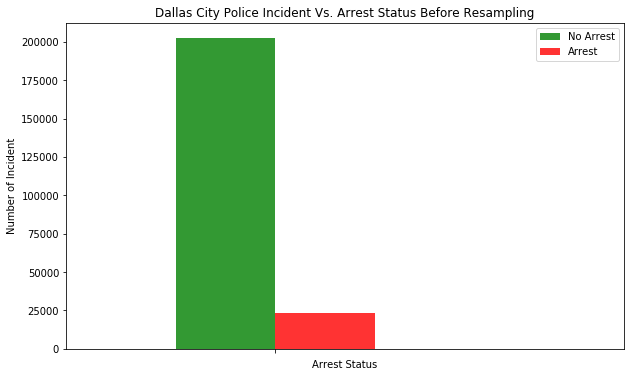

In [13]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [14]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=23115,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    23115
0    23115
Name: Arrest_status, dtype: int64

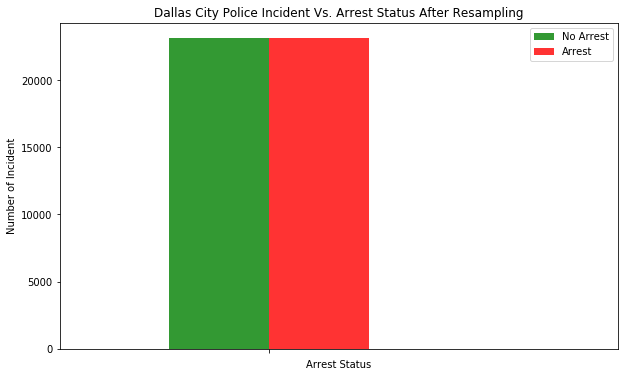

In [15]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()


In [16]:
# copy the down sampling dataset to original incident data frame and continue the anl
incident= df_downsampled.copy()

In [17]:
#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Drug_Related        Social_crime_score      0.842685
Watch               Call_Received_Hour      0.712316
Social_crime_score  Gang_Related_Offense    0.562247
Hate_Crime          Social_crime_score      0.152233
Social_crime_score  Number_of_offense       0.110633
                                              ...   
Number_of_offense   Response_time          -0.058011
Arrest_status       Victim_Age             -0.067700
UCR_Offense_Name    Watch                  -0.103933
Response_time       Arrest_status          -0.174816
UCR_Offense_Name    Arrest_status          -0.310592
Length: 105, dtype: float64


In [18]:

#Drop highly correlated, insignificant and high VIF columns.
incident = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Social_crime_score  Number_of_offense    0.110633
Number_of_offense   Arrest_status        0.081587
Response_time       UCR_Offense_Name     0.072490
Call_Received_Hour  Response_time        0.071725
Victim_Age          IsMale               0.068702
                                           ...   
UCR_Offense_Name    Division            -0.056991
Number_of_offense   Response_time       -0.058011
Victim_Age          Arrest_status       -0.067700
Response_time       Arrest_status       -0.174816
Arrest_status       UCR_Offense_Name    -0.310592
Length: 55, dtype: float64


In [19]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Features with no predictive features with respect to resposne variable
incident = incident.drop(['Arrest_status'],axis=1)


In [20]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
incident = scaler.fit_transform(incident)

#Save as data frames
df_incident = pd.DataFrame(incident)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(incident.values, i) for i in range(incident.shape[1])]
df2_vif["features"] = incident.columns
print("VIF Factors before Scaling")
df2_vif

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [22]:
from sklearn import metrics as mt
import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, incident)
result = logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.624290
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.099     
Dependent Variable: Arrest_status    AIC:              57741.8852
Date:               2018-10-10 19:19 BIC:              57829.2991
No. Observations:   46230            Log-Likelihood:   -28861.   
Df Model:           9                LL-Null:          -32044.   
Df Residuals:       46220            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0242     0.0100     2.4228   0.0154    0.0046    0.0437
x2        0.0256     0.0100     2.5616   0.0104    0.0060 

In [23]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(incident,inci_Y,
                                                    test_size=0.20, random_state=101)

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=1)

In [28]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [29]:
pred = knn.predict(X_test)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix

In [31]:
print(confusion_matrix(y_test,pred))

[[2641 1992]
 [1882 2731]]


In [32]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.58      0.57      0.58      4633
          1       0.58      0.59      0.59      4613

avg / total       0.58      0.58      0.58      9246



In [33]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0,0.5,'Error Rate')

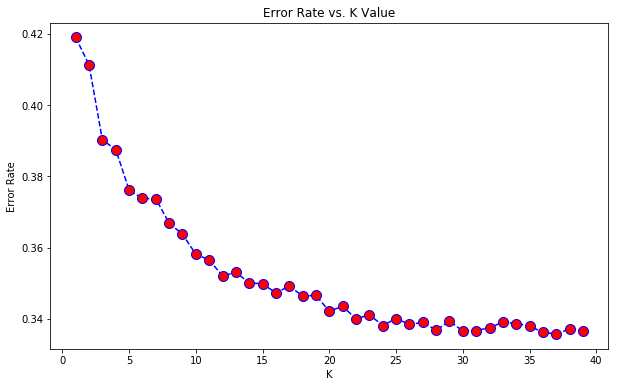

In [34]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [35]:
# FIRST A QUICK COMPARISON TO OUR ORIGINAL K=1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=1


[[2641 1992]
 [1882 2731]]


             precision    recall  f1-score   support

          0       0.58      0.57      0.58      4633
          1       0.58      0.59      0.59      4613

avg / total       0.58      0.58      0.58      9246



In [36]:
# FIRST A QUICK COMPARISON TO OUR ORIGINAL K=37
knn = KNeighborsClassifier(n_neighbors=37)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=37')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=37


[[3166 1467]
 [1637 2976]]


             precision    recall  f1-score   support

          0       0.66      0.68      0.67      4633
          1       0.67      0.65      0.66      4613

avg / total       0.66      0.66      0.66      9246



In [37]:
# FIRST A QUICK COMPARISON TO OUR ORIGINAL K=24
knn = KNeighborsClassifier(n_neighbors=24)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=24')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=24


[[3213 1420]
 [1706 2907]]


             precision    recall  f1-score   support

          0       0.65      0.69      0.67      4633
          1       0.67      0.63      0.65      4613

avg / total       0.66      0.66      0.66      9246

